This workbook will feature the use of a Support Vector Classifier to try and complete our sentiment analysis task. 

Support Vector Classifier (SVC) also known as Support Vector Machine (SVM) for classification is a supervised learning algorithm used for binary and multi-class classification tasks. 

Operating on labeled training data, it aims to find the hyperplane that best separates data points from different classes while maximizing the margin: the distance between the hyperplane and the nearest data points. Utilizing support vectors, which are the data points closest to the hyperplane, the algorithm finds the optimal hyperplane by solving an optimization problem. In cases where data is not linearly separable, SVCs employ the kernel trick, mapping the data into a higher-dimensional space where it becomes linearly separable. This allows SVCs to handle complex datasets with non-linear boundaries effectively. 

SVCs perform well in multiple contexts and domains including NLP tasks. Despite their effectiveness, SVCs require careful hyperparameter tuning and can be computationally expensive, especially for large datasets.

## Setup & Imports

In [1]:
# Imports and Setup
import os
import re
import email
import random
import collections
import itertools
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from string import punctuation
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk import classify
from sklearn import metrics, preprocessing, feature_extraction, linear_model, naive_bayes, ensemble, pipeline, svm, model_selection, decomposition
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import tree, datasets
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# Tell TensorFlow to run all deep learning on GPU:
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Feature extractor and vectorizer, to produce TF-IDF document matrix:
def feature_vectorizer(corpus):
    sa_stop_words = nltk.corpus.stopwords.words('english')
    ''' Create a list of exceptions, as these stopwords may change a sentence's sentiment if removed. '''
    sa_white_list = ['what', 'but', 'if', 'because', 'as', 'until', 'against', 'up', 'down', 'in', 'out',
                    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'why',
                    'how', 'all', 'any', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
                    'same', 'so', 'than', 'too', 'can', 'will', 'just', 'don', 'should']
    ''' Remove stop words except for those specified in the white list. '''
    sa_stop_words = [sw for sw in sa_stop_words if sw not in sa_white_list]
    ''' Instantiate the vectorizer. '''
    count_vectorizer = feature_extraction.text.CountVectorizer(
        lowercase = True,
        tokenizer = nltk.word_tokenize,
        min_df=2, # this means the term frequency must be 2 or higher.
        ngram_range=(1,2),
        stop_words=sa_stop_words
    )
    ''' Run the vectorizer on the body of text ('corpus'). '''
    processed_corpus = count_vectorizer.fit_transform(corpus)
    processed_corpus = feature_extraction.text.TfidfTransformer().fit_transform(processed_corpus)
    return processed_corpus

def data_integrity_check(df, title='', include_non_numeric=True):
    '''Check for nulls, duplicates, etc and perform basic EDA.'''
    results = []
    for col in df:
        result = {
            'Column': col,
            'Null Values': df[col].isnull().sum(),
            'Duplicate Values': df[col].duplicated().sum(),
            'Data Type': df[col].dtype
        }
        if include_non_numeric or df[col].dtype in ['int64', 'float64']:
            result['Unique Values'] = df[col].nunique()
            if df[col].dtype in ['int64', 'float64']:
                result['Mean'] = df[col].mean()
                result['Median'] = df[col].median()
                result['Mode'] = stats.mode(df[col])
                result['Range'] = df[col].max() - df[col].min()
                result['Skew'] = df[col].skew()
                result['Kurtosis'] = df[col].kurtosis()
        if df[col].dtype == 'object':  
            result['Min Text Length'] = df[col].str.len().min()
            result['Max Text Length'] = df[col].str.len().max()
            '''Calculate mean and median text lengths'''
            text_lengths = df[col].str.len()
            result['Mean Text Length'] = np.mean(text_lengths)
            result['Median Text Length'] = np.median(text_lengths)
        results.append(result)
    result_df = pd.DataFrame(results)
    result_df['Source'] = title
    return result_df

# Prints performance metrics for classifiers:
def print_classification_report(y_true, y_pred):
    '''Get a classification report for performance metric inspection.'''
    report = classification_report(y_true, y_pred)
    print(report)

In [3]:
# Import dataset from preprocessing outputs:
df_sa = pd.read_csv('lsa_train_output.csv')
print(df_sa.shape)

# Reimport training labels:
df_train = pd.read_csv('sa_train.csv')
print(df_train.shape)

# Training data split
X_training = df_sa
y = df_train[df_train.columns[2:]].values
X_train, X_test, y_train, y_test = train_test_split(X_training, y, test_size = 0.3, random_state=123)

# Classification labels for test data:
df_test_labels = pd.read_csv('sa_test_labels.csv')

# Test data with text only:
df_test_data = pd.read_csv('lsa_test_output.csv')

# Ensure binary nature of test labels:
df_test_labels[df_test_labels == -1] = 1
for col in df_test_labels:
    unique_values = df_test_labels[col].unique()
print(f'Data check: ', unique_values)

(159571, 400)
(159571, 8)
Data check:  [1 0]


# Classification

In [4]:
# Define common hyperparameter settings for GridSearch:
param_grid_svc = {'estimator__gamma': ['scale', 'auto']}  

# Grid search for Support Vector Classifier (SVC)
multi_classifier_svc = MultiOutputClassifier(SVC(kernel='rbf'))
grid_search_svc = GridSearchCV(multi_classifier_svc, param_grid_svc, n_jobs=10) 
grid_search_svc.fit(X_train, y_train)
print('Best Support Vector Classifier (SVC) Model Performance: {:.4f}'.format(grid_search_svc.best_score_))
print('Best Support Vector Classifier (SVC) Model Parameters:', grid_search_svc.best_params_)

Best Support Vector Classifier (SVC) Model Performance: 0.9129
Best Support Vector Classifier (SVC) Model Parameters: {'estimator__gamma': 'scale'}


In [5]:
# Print classes with matching number for reference:
class_mapping = {
    0: 'Toxic',
    1: 'Severely Toxic',
    2: 'Obscene',
    3: 'Threat',
    4: 'Insult',
    5: 'Identity Hate'
}

# Instantiate Support Vector Classifier (SVC) with best parameters:
best_svc_params = grid_search_svc.best_params_
C = best_svc_params['estimator__gamma']
best_svc_classifier = SVC(kernel = 'rbf', gamma = 'scale')
best_multi_classifier_svc = MultiOutputClassifier(best_svc_classifier)
best_multi_classifier_svc.fit(X_train, y_train)
y_pred_svc = best_multi_classifier_svc.predict(X_test)
print("Classification Report for Support Vector Classifier (SVC):")
print(classification_report(y_test, y_pred_svc, target_names=class_mapping.values()))

Classification Report for Support Vector Classifier (SVC):
                precision    recall  f1-score   support

         Toxic       0.91      0.53      0.67      4478
Severely Toxic       0.51      0.07      0.12       476
       Obscene       0.90      0.61      0.73      2499
        Threat       0.00      0.00      0.00       139
        Insult       0.79      0.50      0.61      2321
 Identity Hate       0.75      0.04      0.08       426

     micro avg       0.87      0.49      0.63     10339
     macro avg       0.64      0.29      0.37     10339
  weighted avg       0.84      0.49      0.61     10339
   samples avg       0.05      0.04      0.04     10339



Interestingly, SVC seems to have good precision for classifying hateful content when our other classifiers so far have failed to meet expectations. So far, no models have done well with classifying threatening content.

In [6]:
# Input data/feature split:
X_testing = df_test_data
y_true = df_test_labels[df_test_labels.columns[1:]].values

# Run LR classifier on test dataset:
y_pred_svc = best_multi_classifier_svc.predict(X_testing)
print(classification_report(y_true, y_pred_svc, target_names=class_mapping.values()))

                precision    recall  f1-score   support

         Toxic       0.64      0.10      0.17     95276
Severely Toxic       0.00      0.00      0.00     89553
       Obscene       0.61      0.04      0.08     92877
        Threat       0.00      0.00      0.00     89397
        Insult       0.60      0.01      0.02     92613
 Identity Hate       0.00      0.00      0.00     89898

     micro avg       0.62      0.03      0.05    549614
     macro avg       0.31      0.03      0.05    549614
  weighted avg       0.31      0.03      0.05    549614
   samples avg       0.06      0.02      0.03    549614



In [10]:
# Let's check out some confusion matrices:
cm_svc = multilabel_confusion_matrix(y_true, y_pred_svc)

# Printing confusion matrices:
print("\nConfusion Matrix for Support Vector Classifier:")
for i, cm in enumerate(cm_svc):
    class_name = class_mapping[i]
    print(f"\nClass {class_name}:\n{cm}")


Confusion Matrix for Support Vector Classifier:

Class Toxic:
[[52596  5292]
 [86031  9245]]

Class Severely Toxic:
[[63611     0]
 [89553     0]]

Class Obscene:
[[57575  2712]
 [88707  4170]]

Class Threat:
[[63767     0]
 [89397     0]]

Class Insult:
[[59899   652]
 [91630   983]]

Class Identity Hate:
[[63266     0]
 [89898     0]]


To help with interpretation: https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

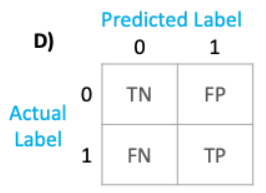